In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette('Set2')


# 1. Overview

## What is  outliers?

They are extreme high or low values.


## Where do they come from?

well, there are many reasons:

- the data itself is an extreme value

- introduced by human or mechanical error

- imputed by replacing missing values



## How do we detect them?

- visualisation
 - box plot
 - histgram
 - scatterplot

- IQR

- Z-score

- Kmeans


## How do we deal with them?

- Trimming

- Chopp off

- Discretization




# 2. Load Data

### Data 1

In [2]:
# !kaggle datasets download -d wordsforthewise/lending-club -p data


In [3]:
data = pd.read_csv('./data/accepted_2007_to_2018Q4.csv', usecols=['annual_inc'], nrows=30000)

data.describe()


,annual_inc
count,3.000000e+04
mean,7.888726e+04
std,8.537007e+04
min,0.000000e+00
25%,4.800000e+04
50%,6.682500e+04
75%,9.500000e+04
max,8.700000e+06


### Data 2

In [4]:
# !kaggle datasets download -d austinreese/craigslist-carstrucks-data -p data

In [5]:

df_vehicles = pd.read_csv('./data/vehicles.csv')

df_vehicles = df_vehicles.drop(['Unnamed: 0'], axis=1)


In [6]:
df_vehicles.describe()


,id,price,year,odometer,lat,long
count,4.582130e+05,4.582130e+05,457163.000000,4.029100e+05,450765.000000,450765.000000
mean,7.235233e+09,4.042093e+04,2010.746067,1.016698e+05,38.531925,-94.375824
std,4.594362e+06,8.194599e+06,8.868136,3.228623e+06,5.857378,18.076225
min,7.208550e+09,0.000000e+00,1900.000000,0.000000e+00,-82.607549,-164.091797
25%,7.231953e+09,4.900000e+03,2008.000000,4.087700e+04,34.600000,-110.890427
50%,7.236409e+09,1.099500e+04,2013.000000,8.764100e+04,39.244500,-88.314889
75%,7.239321e+09,2.149500e+04,2016.000000,1.340000e+05,42.484503,-81.015022
max,7.241019e+09,3.615215e+09,2021.000000,2.043756e+09,82.049255,150.898969


In [7]:
df_price = df_vehicles[['price']]

df_odometer = df_vehicles[['odometer']]


### Data 3

In [10]:
# !kaggle datasets download -d abcsds/pokemon -p data


# 3. Outlier Detection

## Visualisation

- box plot

- scatter plot

- histgram


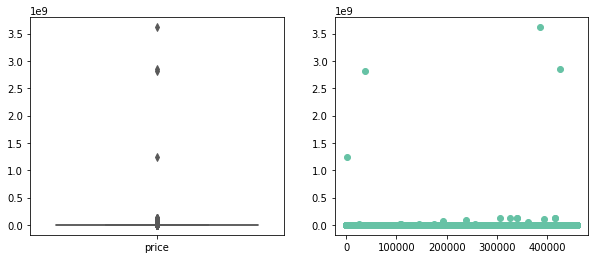

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.boxplot(data=df_price, ax=ax[0])
ax[1].scatter(np.arange(len(df_price)), df_price)

plt.show()


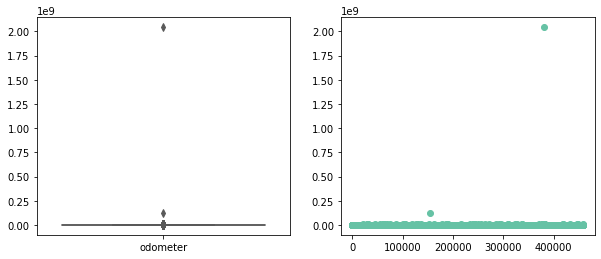

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.boxplot(data=df_odometer, ax=ax[0])
ax[1].scatter(np.arange(len(df_odometer)), df_odometer)

plt.show()


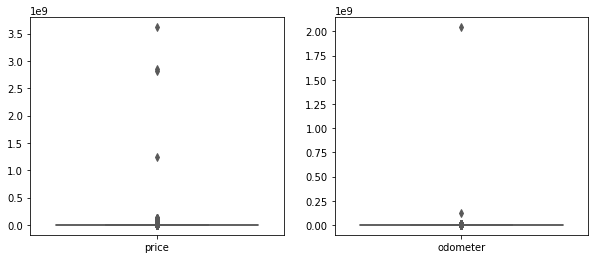

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.boxplot(data=df_price, ax=ax[0])
sns.boxplot(data=df_odometer, ax=ax[1])

plt.show()


In [13]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# sns.histplot(data=data, x='annual_inc', bins=500, ax=ax[0])
# sns.histplot(data=data, x='annual_inc', bins=500, ax=ax[1])
# ax[1].set_xlim(0, 500000)


## Extreme Value Analysis

```
IQR detection = 75% - 25%
upper boundary = 75% + 1.5 * IQR
lower boundary = 25% - 1.5*IQR
```

In [14]:
def cutIQR(df, q2=0.25, q3=0.75, r=1.5):
    q3 = df.quantile(q3)
    q2 = df.quantile(q2)

    IQR = q3 - q2
    
    upper = q3 + r*IQR
    lower = q2 - r*IQR
    
    return upper, lower


In [15]:
upper_price, lower_price = cutIQR(df_price)
upper_percent = (df_price > upper_price).sum() / len(df_price)

upper_extreme_price, lower_extreme_price = cutIQR(df_price, r=3)
upper_extreme_percent = (df_price > upper_extreme_price).sum() / len(df_price)

pd.DataFrame([upper_percent[0], upper_extreme_percent[0]], 
             columns=['Percent'], index=['upper', 'upper extreme'])


,Percent
upper,0.027948
upper extreme,0.004105


In [16]:
upper_odometer, lower_odometer = cutIQR(df_odometer)
upper_odometer_percent = (df_odometer > upper_odometer).sum() / len(df_odometer)

upper_extreme_odometer, lower_extreme_odometer = cutIQR(df_odometer, r=3)
upper_extreme_odometer_percent = (df_odometer > upper_extreme_odometer).sum() / len(df_odometer)

pd.DataFrame([upper_odometer_percent[0], upper_extreme_odometer_percent[0]], 
             columns=['Percent'], index=['upper', 'upper extreme'])



,Percent
upper,0.008210
upper extreme,0.002401


## Z-score

It measures how many standard deviations a given observation is far from the mean.

Data that far away from the center, say `3`, are considered as outerliers.


In [17]:
from scipy import stats

z_data = stats.zscore(df_price)

np.where(z_data>3)


(array([  1622,  38375, 191736, 238861, 306217, 326182, 339197, 339213,
        362163, 385434, 393667, 414603, 414605, 425188]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

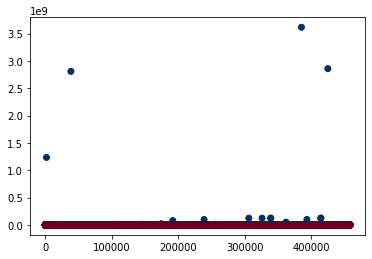

In [18]:
threshold=3
indices=np.zeros(len(df_price))
indices[np.where(z_data > threshold)[0]] = 1

plt.scatter(np.arange(len(df_price)), df_price, c=indices,cmap='RdBu')
plt.show()


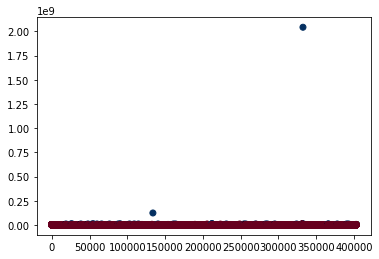

In [19]:
cleaned_odometer = df_odometer.dropna()

z_odometer = stats.zscore(cleaned_odometer)

threshold=3
indices=np.zeros(len(cleaned_odometer))
indices[np.where(z_odometer > threshold)[0]] = 1

plt.scatter(np.arange(len(cleaned_odometer)), cleaned_odometer, c=indices, cmap='RdBu')
plt.show()


## Clustering

Group similar data into groups.


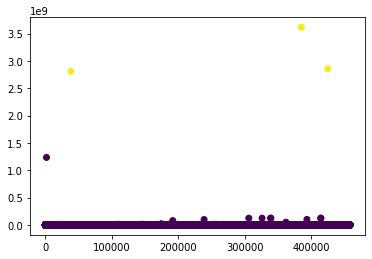

In [177]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(df_price)

plt.scatter(np.arange(len(df_price)), df_price, c=kmeans.labels_)
plt.show()


# 4. Processing Outliers

## Trimming

In [17]:
df_odometer.max()


odometer    2.043756e+09
dtype: float64

In [18]:
removed_odometer = df_odometer[df_odometer!=df_odometer.max()]

removed_odometer.max()


odometer    123459789.0
dtype: float64

In [19]:
removed_odometer=removed_odometer[removed_odometer!=removed_odometer.max()]


/Users/wuxiaopan/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/wuxiaopan/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


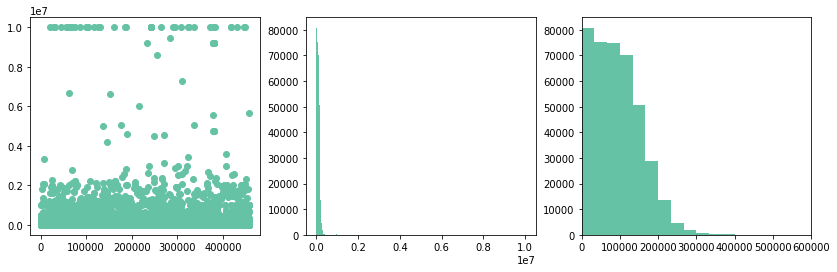

In [20]:
fig,ax= plt.subplots(1, 3, figsize=(14, 4))
ax[0].scatter(np.arange(len(removed_odometer)), removed_odometer)
ax[1].hist(removed_odometer,bins=300)
ax[2].hist(removed_odometer,bins=300)
ax[2].set_xlim(0, 600000)
plt.show()

Removing two extreme outliers of the variable `odometer`, the distribution now looks less skewed.


## Chopping Off

In [24]:
df_price_copy = df_vehicles['price']

# (0, upper_price]
df_price_copy.loc[df_price_copy>30000] = upper_price.values[0]
df_price_copy = df_price_copy[df_price_copy>0]
df_price_copy.max()


/Users/wuxiaopan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


46387.5

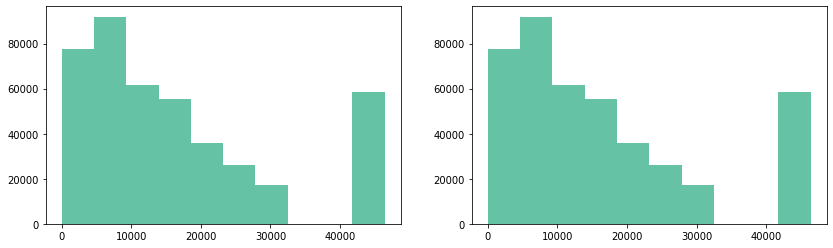

In [25]:
fig,ax= plt.subplots(1, 2, figsize=(14, 4))
ax[0].hist(df_price_copy,bins=10)
ax[1].hist(df_price_copy,bins=10)
plt.show()


## Discretization

### Equal Frequency binning

In [35]:
df_price = df_vehicles[['price']]


In [37]:
item_binned, intervals = pd.qcut(df_price['price'], 10, labels=None, retbins=True, precision=3, duplicates='drop')

print(intervals)

binned_price = pd.concat([item_binned, df_vehicles['price']], axis=1)

binned_price.columns = ['bins', 'price']

binned_price.groupby('bins')['price'].count()

[    0.    651.   3800.   5950.   7999.  10995.  14590.  18600.  24991.
 46387.5]


bins
(-0.001, 651.0]       45823
(651.0, 3800.0]       46637
(3800.0, 5950.0]      45079
(5950.0, 7999.0]      46646
(7999.0, 10995.0]     46562
(10995.0, 14590.0]    44200
(14590.0, 18600.0]    45833
(18600.0, 24991.0]    45818
(24991.0, 46387.5]    91615
Name: price, dtype: int64


### Equal width binning
$$
width = (max-min)/N
$$


In [52]:
df_price = df_vehicles['price']


In [53]:
max_price, min_price = int(df_price.max()), int(df_price.min())
N = 5
width = int((max_price - min_price) / N)
print(min_price, max_price, width)

binss = []
for i in range(min_price, max_price, width):
    binss.append(i)
labels = [ 'Bin'+str(i) for i in range(1, len(binss))]

binss, labels


0 46387 9277


([0, 9277, 18554, 27831, 37108, 46385],
 ['Bin1', 'Bin2', 'Bin3', 'Bin4', 'Bin5'])

In [54]:
df_price.max()

46387.5

/Users/wuxiaopan/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


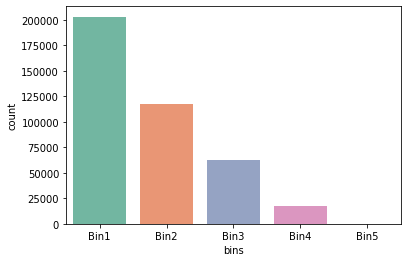

In [55]:
df_price_p = df_vehicles.loc[:, ['price']]

df_price_p.loc[:,'bins']=pd.cut(df_price_p['price'], bins=binss, labels=labels, include_lowest=True)

# b=pd.cut(df_price['price'], bins=bins, include_lowest=True)
# df_price.loc[:,'intervals']=b

sns.countplot(df_price_p.bins)
plt.show()
